In [4]:
# importing libraries
from __future__ import division
import numpy as np#
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
from scipy import stats
import pandas as pd
import itertools

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Auxiliary functions

In [5]:
def intercala_listas(a, b):
    c = list(zip(a, b))
    return [elt for sublist in c for elt in sublist]

def format_names(names):
    names_latex = []
    hi_there = 0
    for n in names:
        if n=='lsig_c':
            hi_there+=1
            if hi_there==2:
                n += '2'
        if n[-1]=='2':
            n = n.replace('2','^x')
        if n[0]=='s':
            n = n.replace('sig',r'$\sigma')
            n += '$'
        elif n[:2]=='ls':
            n = n.replace('lsig',r'$log(\sigma')
            n += ')$'
        elif n[:2]=='ps':
            n = n.replace('psig',r'$\sigma')
            n += '$%'
        elif n[:2]=='pl':
            n = n.replace('plsig',r'$log(\sigma')
            n += ')$%'
        elif n=="mu_y":
            n = n.replace('mu',r'$\mu')
            n += '$'
        else:
            n = n.replace('lpsig',r'$log(\sigma')
            n += '^x)$%'
    #     print n
        names_latex.append(n)
    return names_latex

def format_short(AllTab):
    tab_short = AllTab.iloc[-8:].copy()
    tab_short.rename(index={'lsig_y2': 'log_variance', 
                                   'sig_x': 'spell_number',
                                  'lsig_c': 'constant',
                                   'lsig_e2': 'duration_dependence',
                                   'lsig_b2': 'heterogeneity',
                                   'lpsig_x': 'spell_number_percentage',
                                  'lpsig_x': 'spell_number_percentage',
                                  'lpsig_e': 'duration_dependence_percentage',
                                  'lpsig_b': 'heterogeneity_percentage'},inplace='True')
    tab_short = tab_short.append(pd.Series(1-AllTab.iloc[-3:].sum(),name='constant_percentage'))
    tab_short = tab_short.reindex(['log_variance', 'spell_number', 'constant', 'duration_dependence',
           'heterogeneity', 'constant_percentage','spell_number_percentage',
           'duration_dependence_percentage', 'heterogeneity_percentage'])
    return tab_short

def format_very_short(AllTab):
    tab_short = AllTab.iloc[-3:].copy()
    tab_short = tab_short.T
    tab_short.reset_index(level=0,inplace=True)
    tab_short['shareC'] = 1-AllTab.iloc[-3:].sum().values
    tab_short['var'] = AllTab.iloc[-8].values
    tab_short['mean_days'] = AllTab.loc['mu_y'].values
    tab_short.rename(columns={'lpsig_x': 'shareS',
                            'lpsig_e': 'shareDD',
                            'lpsig_b': 'shareH',
                             'index':'cat'},inplace='True')
    tab_short = tab_short[['shareC','shareDD','shareH','shareS','cat','var','mean_days']]
    return tab_short

def format_very_short_levels(AllTab):
    tab_short = AllTab.T[['psig_c','psig_e','psig_b']]
    tab_short = tab_short
    tab_short.reset_index(level=0,inplace=True)
#     tab_short['shareC'] = 1-AllTab.iloc[-3:].sum().values
    tab_short['var'] = AllTab.loc['sig_y'].values
    tab_short['mean_days'] = AllTab.loc['mu_y'].values
    tab_short.rename(columns={'psig_c': 'shareC',
                            'psig_e': 'shareDD',
                            'psig_b': 'shareH',
                             'index':'cat'},inplace='True')
    tab_short = tab_short[['shareC','shareDD','shareH','cat','var','mean_days']]
    return tab_short

def format_column_names(column_names):
    var_name = []
    type1 = []
    for name in column_names:
        split = name.split(',')
        n,t = split[0],split[1:]
        var_name.append(n)
        type1.append(t)
    return var_name,type1

def read_results(inputfile):
    table_raw = np.empty(23)
    names = []
    sigmas = []
    column_names = []
    noobs = []
    results_follow = 0
    first_row = 1
    f = open(inputfile,'r')
    for line in f:
        words = line.split()
#         print(words)
        if len(words)>1 and words[1]=="******":
            column_names.append("".join(words[2:-1]))
            results_follow=1
        elif results_follow==1 and len(words)==7:
            if first_row==1:
                names.append(words[0])
            sigmas.append(float(words[3]))
            if words[0]=='lpsig_b':
                results_follow=0
                table_raw = np.vstack((table_raw,np.array(sigmas)))
                noobs.append(int(words[2].replace(',',"")))
                sigmas = []
                first_row = 0
    f.close()
    return table_raw, names, column_names, noobs

def read_descriptive_stats(inputfile):
    table_raw = np.zeros((5,11,7))
    var_names = []
    row_n = 0
    table_n = 0
    column_names = []
    results_follow = 0
    names_done = 0
    f = open(inputfile,'r')
    for line in f:
        words = line.split()
        if len(words)>1 and words[0] == "Variable":
            results_follow=1
            if names_done == 0:
                stats_names = words[2:]       
        elif len(words)>1 and results_follow==1:
            if words[0]!='before92':
                if names_done ==0:
                    column_names.append(words[0])
                idx = 0
                for w in words[2:]: 
                    w = w.replace(",","")
                    table_raw[idx,row_n,table_n] = np.array(w)
                    idx+=1
                row_n += 1

            elif words[0]=='before92':
                if names_done ==0:
                    column_names.append(words[0])
                    names_done = 1 
                idx=0
                for w in words[2:]: 
                    w = w.replace(",","")
                    table_raw[idx,row_n,table_n] = np.array(w)
                    idx+=1
                results_follow=0
                table_n +=1
                row_n = 0
    f.close()
    column_names_format =  ['duration','duration_last','age','female','college',
                  'year_of_spell','last_T','last_P','last_A','before_84','before_92']
    table_names_format = ['Raw', 'LTU', 'STU_noAjd', 'STU','STU_Recalls', 'NE_noAjd', 'NE']
    means_table = pd.DataFrame(table_raw[1,:,:].T, columns=column_names_format) #, index=names_latex
    means_table['version'] = table_names_format
    stds_table = pd.DataFrame(table_raw[2,:,:].T, columns=column_names_format) #, index=names_latex
    stds_table['version'] = table_names_format

    final_table = pd.concat([means_table, stds_table]).sort_index(kind='merge')
    final_table['stat'] = ['mean','std']*7
    final_table = final_table[list(final_table.columns[-2:])+list(final_table.columns[:-2])]
    
    return final_table, means_table

def read_descriptive_stats_T(inputfile):
    table_raw = np.zeros((5,12,7))
    var_names = []
    row_n = 0
    table_n = 0
    column_names = []
    results_follow = 0
    names_done = 0
    f = open(inputfile,'r')
    for line in f:
        words = line.split()
        if len(words)>1 and words[0] == "Variable":
            results_follow=1
            if names_done == 0:
                stats_names = words[2:]       
        elif len(words)>1 and results_follow==1:
            if words[0]!='before92':
                if names_done ==0:
                    column_names.append(words[0])
                idx = 0
                for w in words[2:]: 
                    w = w.replace(",","")
                    table_raw[idx,row_n,table_n] = np.array(w)
                    idx+=1
                row_n += 1

            elif words[0]=='before92':
                if names_done ==0:
                    column_names.append(words[0])
                    names_done = 1 
                idx=0
                for w in words[2:]: 
                    w = w.replace(",","")
                    table_raw[idx,row_n,table_n] = np.array(w)
                    idx+=1
                results_follow=0
                table_n +=1
                row_n = 0
    f.close()
#     print(table_raw[1,:,:].T)
    column_names_format =  ['duration','duration_last','age','female','college',
                  'year_of_spell','last_T','last_P','last_A','TempContracts','before_84','before_92']
    table_names_format = ['Raw', 'LTU', 'STU_noAjd', 'STU','STU_Recalls', 'NE_noAjd', 'NE']
    means_table = pd.DataFrame(table_raw[1,:,:].T, columns=column_names_format) #, index=names_latex
    means_table['version'] = table_names_format
    stds_table = pd.DataFrame(table_raw[2,:,:].T, columns=column_names_format) #, index=names_latex
    stds_table['version'] = table_names_format

    final_table = pd.concat([means_table, stds_table]).sort_index(kind='merge')
    final_table['stat'] = ['mean','std']*7
    final_table = final_table[list(final_table.columns[-2:])+list(final_table.columns[:-2])]
    
    return final_table, means_table

## Reading the data
### New version

In [3]:
table_raw, names, column_names, noobs = read_results('results/all_results96_30.log')
table_raw_r, names_r, column_names_r, noobs_r = read_results('results/table_recalls.log')
names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab96_noA= format_very_short(AllTab)
short_tab96_noA['N'] = noobs
short_tab96_noA.round(3).to_stata('results/all_results96_35.dta')
short_tab96_noA
short_tab96_noA.T

,0,1,2,3
shareC,1.07676,1.00233,0.852591,0.710733
shareDD,-0.268197,-0.205716,-0.0033582,0.125063
shareH,0.187508,0.202306,0.150108,0.162964
shareS,0.0039294,0.0010807,0.0006588,0.0012401
cat,Raw,LTU,STU+SpellAdj,NE+SpellAdj
var,1.52767,1.64111,1.92934,2.31442
mean_days,185.693,256.534,271.493,249.614
N,374168,339246,466490,647060


In [4]:
table_raw, names, column_names, noobs = read_results('results/all_results96_15.log')
table_raw_r, names_r, column_names_r, noobs_r = read_results('results/table_recalls.log')
names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab96_noA= format_very_short(AllTab)
short_tab96_noA['N'] = noobs
short_tab96_noA.round(3).to_stata('results/all_results96_15.dta')
short_tab96_noA
short_tab96_noA.T

,0,1,2,3
shareC,1.0502,0.981156,0.73464,0.604382
shareDD,-0.259841,-0.211724,0.109799,0.212747
shareH,0.202526,0.227717,0.15359,0.180498
shareS,0.0071199,0.0028502,0.0019708,0.0023726
cat,Raw,LTU,STU+SpellAdj,NE+SpellAdj
var,1.56631,1.67653,2.2391,2.72168
mean_days,182.914,248.128,254.683,223.084
N,421054,381522,554766,735266


In [42]:
table_raw, names, column_names, noobs = read_results('results/all_results96_30.log')
table_raw_r, names_r, column_names_r, noobs_r = read_results('results/table_recalls.log')
names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab96_noA= format_very_short_levels(AllTab)
short_tab96_noA['N'] = noobs
short_tab96_noA.round(3).to_stata('results/all_results96_35_levels.dta')
short_tab96_noA
short_tab96_noA.T

,0,1,2,3
shareC,0.619246,0.587667,0.527899,0.464011
shareDD,0.278298,0.286383,0.355344,0.427305
shareH,0.102456,0.12595,0.116756,0.108684
cat,Raw,LTU,STU+SpellAdj,NE+SpellAdj
var,66722.9,142532,179276,175350
mean_days,185.693,256.534,271.493,249.614
N,374168,339246,466490,647060


In [32]:
table_raw, names, column_names, noobs = read_results('results/all_results96.log')
# table_raw_r, names_r, column_names_r, noobs_r = read_results('results/table_recalls.log')
# AllTab_r = pd.DataFrame(table_raw_r[1:,:].T, index=names_latex, columns=["Recalls",])
names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
# AllTab['Recalls'] = AllTab_r
short_tab96_noA= format_very_short(AllTab)
short_tab96_noA['N'] = noobs
short_tab96_noA.round(3).to_stata('results/all_results96.dta')
short_tab96_noA
short_tab96_noA.T

,0,1,2,3,4
shareC,1.23166,1.09085,0.692237,0.559959,0.494946
shareDD,-0.471725,-0.340893,0.117102,0.251383,0.261695
shareH,0.228955,0.24463,0.190138,0.183208,0.239065
shareS,0.0111114,0.0054137,0.000523,0.0054506,0.0042932
cat,Raw,LTU,STU,STU+SpellAdj,NE+SpellAdj
var,1.33554,1.50794,2.37626,2.9376,3.32346
mean_days,188.472,251.358,258.246,225.206,181.835
N,441650,400714,672456,672456,873268


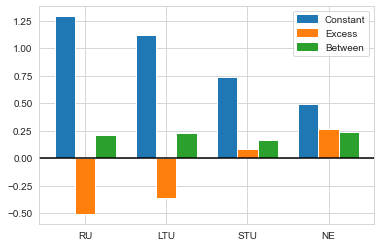

In [38]:
table_plot = short_tab96_noA.T
table_plot.loc[['shareC','shareDD','shareH']]
colours = sns.color_palette()[0:3]

for i in range(4):
    shift= i*2
    plt.bar(np.arange(0+shift,1.5+shift,0.5),table_plot[i].loc[['shareC','shareDD','shareH']],width=0.5,color=colours)
plt.xticks([])
labels = ['Constant','Excess','Between']
# labels = list(colors.keys())
plt.xticks(np.arange(0.5,8,2),['RU','LTU','STU','NE'])
plt.axhline(c='k')
handles = [plt.Rectangle((0,0),1,1, color=colours[i]) for i in range(3)]
plt.legend(handles, labels)
plt.show()

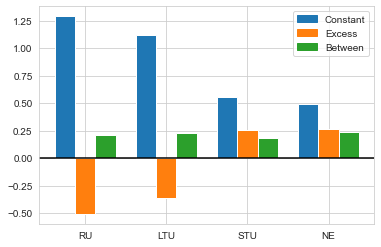

In [40]:
table_plot = short_tab96_noA.T
table_plot.loc[['shareC','shareDD','shareH']]
colours = sns.color_palette()[0:3]

for i in range(4):
    shift= i*2
    plt.bar(np.arange(0+shift,1.5+shift,0.5),table_plot[i].loc[['shareC','shareDD','shareH']],width=0.5,color=colours)
plt.xticks([])
labels = ['Constant','Excess','Between']
# labels = list(colors.keys())
plt.xticks(np.arange(0.5,8,2),['RU','LTU','STU','NE'])
plt.axhline(c='k')
handles = [plt.Rectangle((0,0),1,1, color=colours[i]) for i in range(3)]
plt.legend(handles, labels)
plt.show()

In [33]:
table_raw, names, column_names, noobs = read_results('results/all_results_sex_96.log')

names_latex = names
var_names, sex_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['gender'] = list(itertools.chain.from_iterable(sex_names))
short_tab['N'] = np.array(noobs)
short_tab.round(3).to_stata('results/results_sex_96.dta')
short_tab

,shareC,shareDD,shareH,shareS,cat,var,mean_days,gender,N
0,0.582426,0.235462,0.177853,0.004258,STU+SpellAdj,2.824279,177.7700,men,370210
1,0.554640,0.278814,0.159243,0.007303,STU+SpellAdj,2.965769,283.3077,women,302246


In [5]:
table_raw, names, column_names, noobs = read_results('results/all_results_educ_96.log')

names_latex = names
var_names, educ_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['educ'] = list(itertools.chain.from_iterable(educ_names))
short_tab['N'] = np.array(noobs)
short_tab.round(3).to_stata('results/results_educ_96.dta')
short_tab[short_tab.cat=='STU+SpellAdj']

,shareC,shareDD,shareH,shareS,cat,var,mean_days,educ,N
0,0.540402,0.297464,0.155103,0.007031,STU+SpellAdj,3.043908,197.4635,college,101002
1,0.564513,0.243246,0.187047,0.005194,STU+SpellAdj,2.913899,230.1088,nocollege,571454


In [7]:
table_raw, names, column_names, noobs = read_results('results/all_results96_x.log')

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab96_noA_x= format_very_short(AllTab)
short_tab96_noA_x['N'] = np.array(noobs)
short_tab96_noA_x.round(3).to_stata('results/all_results_96_x.dta')
short_tab96_noA_x

,shareC,shareDD,shareH,shareS,cat,var,mean_days,N
0,0.559959,0.251383,0.162406,0.026252,STU+SpellAdj,2.937599,225.2056,672456


In [6]:
table_raw, names, column_names, noobs = read_results('results/BC_educ.log')

names_latex = names
var_names, educ_names = format_column_names(column_names)
data_names = np.array(educ_names)
var_names = ['STU+SpellAdj','STU+SpellAdj','STU+SpellAdj','STU+SpellAdj']
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['educ'] = data_names[:,1]
short_tab['period'] = data_names[:,0]
short_tab['N'] = noobs
short_tab.round(3).to_stata('results/results_BC_educ.dta')
short_tab

,shareC,shareDD,shareH,shareS,cat,var,mean_days,educ,period,N
0,0.570749,0.238800,0.174270,0.016181,STU+SpellAdj,2.882064,155.1477,college,2002-2007,43098
1,0.602440,0.168305,0.216461,0.012794,STU+SpellAdj,2.730454,166.4059,nocollege,2002-2007,258384
2,0.659888,0.211688,0.121083,0.007340,STU+SpellAdj,2.492747,174.1999,college,2008-2013,44230
3,0.702882,0.162291,0.125801,0.009026,STU+SpellAdj,2.340270,205.7451,nocollege,2008-2013,288454


In [88]:
table_raw, names, column_names, noobs = read_results('results/BC_sex.log')

names_latex = names
var_names, educ_names = format_column_names(column_names)
data_names = np.array(educ_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['educ'] = data_names[:,1]
short_tab['N'] = noobs
short_tab['period'] = data_names[:,0]
short_tab.replace({'STU+Spellcorrection': 'STU+SpellAdj'}, inplace=True)
short_tab.round(3).to_stata('results/results_BC_sex.dta')
short_tab

,shareC,shareDD,shareH,shareS,cat,var,mean_days,educ,N,period
0,0.626625,0.160319,0.199611,0.013445,STU+SpellAdj,2.625072,129.7104,men,159590,2002-2007
1,0.605670,0.214931,0.164177,0.015221,STU+SpellAdj,2.715892,202.8070,women,131188,2002-2007
2,0.718414,0.160446,0.113999,0.007141,STU+SpellAdj,2.289674,193.0493,men,176620,2008-2013
3,0.687038,0.176211,0.121391,0.015360,STU+SpellAdj,2.394241,215.8836,women,139098,2008-2013


In [196]:
table_raw, names, column_names, noobs = read_results('results/all_results96noA_nob0.log')

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab96_noA= format_very_short(AllTab)
short_tab96_noA['N'] = np.array(noobs)
short_tab96_noA.round(3).to_stata('results/all_results96_noA_nob0.dta')
short_tab96_noA

,shareC,shareDD,shareH,shareS,cat,var,mean_days,N
0,1.290153,8.498864,0.206386,-8.995403,Raw,1.274990,190.7582,430272
1,1.123428,7.917593,0.237268,-8.278289,LTU,1.464209,245.1106,430272
2,0.723768,4.837201,0.185434,-4.746403,STU,2.272735,248.3083,656600
3,0.577915,3.565112,0.174557,-3.317584,STU+SpellAdj,2.846325,215.7076,656600
4,0.569520,3.391531,0.250831,-3.211882,NE(NOSpellAdj),2.888282,230.6004,844674
5,0.499273,2.533661,0.230164,-2.263098,NE+SpellAdj,3.294660,172.9079,844674
6,0.500505,2.569763,0.220459,-2.290727,STU+Recalls+SpellAdj,3.286546,171.7619,794578
7,0.548132,3.206721,0.208818,-2.963671,STU+Blanks+SpellAdj,3.000977,208.1506,731216


In [198]:
(3.565112 -3.317584)/2.846325

0.08696406770133416

In [44]:
table_raw, names, column_names, noobs = read_results('results/all_results96noA_x_noage.log')

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab96_noA_x= format_very_short(AllTab)
short_tab96_noA_x['N'] = np.array(noobs)
short_tab96_noA_x.round(3).to_stata('results/all_results_96_noA_x_noage.dta')
short_tab96_noA_x

,shareC,shareDD,shareH,shareS,cat,var,mean_days,N
0,1.278119,-0.492407,0.194926,0.019363,Raw,1.286996,192.5816,420104
1,1.114078,-0.354731,0.223826,0.016827,LTU,1.476498,247.3988,420104
2,0.716050,0.098722,0.168189,0.017039,STU,2.297234,249.6314,648704
3,0.574052,0.246502,0.153172,0.026274,STU+SpellAdj,2.865479,216.3663,648704
4,0.569520,0.181181,0.235862,0.013437,NE(NOSpellAdj),2.888282,230.6004,844674
5,0.499273,0.266956,0.214887,0.018884,NE+SpellAdj,3.294660,172.9079,844674
6,0.500506,0.275227,0.206612,0.017656,STU+Recalls+SpellAdj,3.286546,171.7619,794578
7,0.545228,0.242018,0.186813,0.025942,STU+Blanks+SpellAdj,3.016965,208.5889,723812


In [194]:
table_raw, names, column_names, noobs = read_results('results/all_results96noA_x_onlygender.log')

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab96_noA_x= format_very_short(AllTab)
short_tab96_noA_x['N'] = np.array(noobs)
short_tab96_noA_x.round(3).to_stata('results/all_results_96_noA_x_onlygender.dta')
short_tab96_noA_x

,shareC,shareDD,shareH,shareS,cat,var,mean_days,N
0,1.290154,-0.507585,0.202907,0.014524,Raw,1.274990,190.7582,430272
1,1.123429,-0.367165,0.230943,0.012793,LTU,1.464209,245.1106,430272
2,0.723769,0.089989,0.176411,0.009832,STU,2.272735,248.3083,656600
3,0.577915,0.242369,0.157456,0.022260,STU+SpellAdj,2.846325,215.7076,656600
4,0.569520,0.181203,0.243439,0.005837,NE(NOSpellAdj),2.888282,230.6004,844674
5,0.499273,0.266956,0.218538,0.015233,NE+SpellAdj,3.294660,172.9079,844674
6,0.500506,0.275227,0.210306,0.013962,STU+Recalls+SpellAdj,3.286546,171.7619,794578
7,0.548133,0.238665,0.190664,0.022539,STU+Blanks+SpellAdj,3.000977,208.1506,731216


In [209]:
table_raw, names, column_names, noobs = read_results('results/all_results96noA_x_onlyage.log')

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab96_noA_x= format_very_short(AllTab)
short_tab96_noA_x['N'] = np.array(noobs)
short_tab96_noA_x.round(3).to_stata('results/all_results_96_noA_x_onlyage.dta')
short_tab96_noA_x

,shareC,shareDD,shareH,shareS,cat,var,mean_days,N
0,1.290154,-0.506324,0.194330,0.021840,Raw,1.274990,190.7582,430272
1,1.123429,-0.364379,0.228188,0.012762,LTU,1.464209,245.1106,430272
2,0.723769,0.088402,0.174001,0.013828,STU,2.272735,248.3083,656600
3,0.577915,0.241340,0.163642,0.017103,STU+SpellAdj,2.846325,215.7076,656600
4,0.569520,0.179317,0.236708,0.014455,NE(NOSpellAdj),2.888282,230.6004,844674
5,0.499273,0.267707,0.221800,0.011220,NE+SpellAdj,3.294660,172.9079,844674
6,0.500505,0.275112,0.213079,0.011304,STU+Recalls+SpellAdj,3.286546,171.7619,794578
7,0.548133,0.239658,0.196422,0.015787,STU+Blanks+SpellAdj,3.000977,208.1506,731216


In [195]:
table_raw, names, column_names, noobs = read_results('results/all_results96noA_x_onlyeduc.log')

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab96_noA_x= format_very_short(AllTab)
short_tab96_noA_x['N'] = np.array(noobs)
short_tab96_noA_x.round(3).to_stata('results/all_results_96_noA_x_onlyeduc.dta')
short_tab96_noA_x

,shareC,shareDD,shareH,shareS,cat,var,mean_days,N
0,1.290154,-0.522763,0.200974,0.031635,Raw,1.274990,190.7582,430272
1,1.123429,-0.381865,0.231662,0.026774,LTU,1.464209,245.1106,430272
2,0.723768,0.066364,0.176662,0.033206,STU,2.272735,248.3083,656600
3,0.577915,0.221148,0.168007,0.032930,STU+SpellAdj,2.846325,215.7076,656600
4,0.569520,0.161195,0.239722,0.029563,NE(NOSpellAdj),2.888282,230.6004,844674
5,0.499273,0.248669,0.222590,0.029468,NE+SpellAdj,3.294660,172.9079,844674
6,0.500505,0.257142,0.213259,0.029093,STU+Recalls+SpellAdj,3.286546,171.7619,794578
7,0.548133,0.218323,0.201845,0.031699,STU+Blanks+SpellAdj,3.000977,208.1506,731216


In [174]:
table_raw, names, column_names, noobs = read_results('results/all_results_noA.log')

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab_noA= format_very_short(AllTab)
short_tab_noA['N'] = np.array(noobs)
short_tab_noA.round(3).to_stata('results/all_results_noA.dta')
short_tab_noA

,shareC,shareDD,shareH,shareS,cat,var,mean_days,N
0,1.184699,-0.407468,0.212557,0.010212,Raw,1.388483,248.2181,583378
1,0.982160,-0.233017,0.244355,0.006502,LTU,1.674813,353.9770,583378
2,0.647948,0.145602,0.205472,0.000978,STU,2.538683,367.9815,875468
3,0.512057,0.281527,0.201462,0.004954,STU+SpellAdj,3.212404,332.7510,875468
4,0.501791,0.228445,0.271267,-0.001503,NE(NOSpellAdj),3.278130,347.0905,1120108
5,0.432196,0.308477,0.254194,0.005133,NE+SpellAdj,3.805994,275.1052,1120108
6,0.433513,0.312480,0.248614,0.005393,STU+Recalls+SpellAdj,3.794429,269.1981,1054238
7,0.485477,0.286766,0.223147,0.004610,STU+Blanks+SpellAdj,3.388282,328.4019,971170


In [175]:
table_raw, names, column_names, noobs = read_results('results/all_results_noA_x_noage.log')

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab96_noA_x= format_very_short(AllTab)
short_tab96_noA_x['N'] = np.array(noobs)
short_tab96_noA_x.round(3).to_stata('results/all_results_noA_x_noage.dta')
short_tab96_noA_x

,shareC,shareDD,shareH,shareS,cat,var,mean_days,N
0,1.184699,-0.422714,0.196201,0.041814,Raw,1.388483,248.2181,583378
1,0.982160,-0.247342,0.225093,0.040089,LTU,1.674813,353.9770,583378
2,0.647948,0.123242,0.177813,0.050997,STU,2.538683,367.9815,875468
3,0.512057,0.260855,0.170118,0.056970,STU+SpellAdj,3.212404,332.7510,875468
4,0.501790,0.209258,0.246837,0.042115,NE(NOSpellAdj),3.278130,347.0905,1120108
5,0.432196,0.290620,0.229807,0.047377,NE+SpellAdj,3.805994,275.1052,1120108
6,0.433513,0.294957,0.225657,0.045873,STU+Recalls+SpellAdj,3.794429,269.1981,1054238
7,0.485477,0.266622,0.191771,0.056130,STU+Blanks+SpellAdj,3.388282,328.4019,971170


In [176]:
table_raw, names, column_names, noobs = read_results('results/all_results_noA_x.log')

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab_noA= format_very_short(AllTab)
short_tab_noA['N'] = np.array(noobs)
short_tab_noA.round(3).to_stata('results/all_results_noA_x.dta')
short_tab_noA

,shareC,shareDD,shareH,shareS,cat,var,mean_days,N
0,1.184699,-0.422714,0.196201,0.041814,Raw,1.388483,248.2181,583378
1,0.982160,-0.247342,0.225093,0.040089,LTU,1.674813,353.9770,583378
2,0.647948,0.123242,0.177813,0.050997,STU,2.538683,367.9815,875468
3,0.512057,0.265447,0.156898,0.065599,STU+SpellAdj,3.212404,332.7510,875468
4,0.501790,0.209258,0.246837,0.042115,NE(NOSpellAdj),3.278130,347.0905,1120108
5,0.432196,0.295144,0.220216,0.052444,NE+SpellAdj,3.805994,275.1052,1120108
6,0.433513,0.298551,0.217330,0.050606,STU+Recalls+SpellAdj,3.794429,269.1981,1054238
7,0.485477,0.272990,0.176707,0.064825,STU+Blanks+SpellAdj,3.388282,328.4019,971170


In [177]:
table_raw, names, column_names, noobs = read_results('results/all_results96noA_x.log')

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab96_noA_x= format_very_short(AllTab)
short_tab96_noA_x['N'] = np.array(noobs)
short_tab96_noA_x.round(3).to_stata('results/all_results96_noA_x.dta')
short_tab96_noA_x

,shareC,shareDD,shareH,shareS,cat,var,mean_days,N
0,1.290154,-0.521582,0.184311,0.047117,Raw,1.274990,190.7582,430272
1,1.123429,-0.379343,0.214822,0.041092,LTU,1.464209,245.1106,430272
2,0.723768,0.064751,0.155446,0.056035,STU,2.272735,248.3083,656600
3,0.577915,0.220057,0.139812,0.062216,STU+SpellAdj,2.846325,215.7076,656600
4,0.569520,0.159640,0.219797,0.051042,NE(NOSpellAdj),2.888282,230.6004,844674
5,0.499273,0.249339,0.202666,0.048723,NE+SpellAdj,3.294660,172.9079,844674
6,0.500506,0.257077,0.195543,0.046875,STU+Recalls+SpellAdj,3.286546,171.7619,794578
7,0.548133,0.219106,0.171589,0.061172,STU+Blanks+SpellAdj,3.000977,208.1506,731216


In [178]:
table_raw, names, column_names, noobs = read_results('results/all_results.log')

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab = format_very_short(AllTab)
short_tab['N'] = np.array(noobs)
# AllTab.round(3).to_csv('results/all_results.csv')
short_tab.round(3).to_stata('results/all_results.dta')
short_tab

,shareC,shareDD,shareH,shareS,cat,var,mean_days,N
0,1.184699,-0.407468,0.212557,0.010212,Raw,1.388483,248.2181,583378
1,0.982160,-0.233017,0.244355,0.006502,LTU,1.674813,353.9770,583378
2,0.637702,0.151502,0.209657,0.001138,STU,2.579470,386.1211,924208
3,0.505203,0.278588,0.210961,0.005249,STU+SpellAdj,3.255989,354.1303,924208
4,0.499336,0.227252,0.275013,-0.001601,NE(NOSpellAdj),3.294243,363.4460,1155700
5,0.425915,0.300700,0.267800,0.005585,NE+SpellAdj,3.862121,295.4518,1155700
6,0.427495,0.305841,0.260705,0.005959,STU+Recalls+SpellAdj,3.847846,290.4843,1095058


In [179]:
table_raw, names, column_names, noobs = read_results('results/all_results96.log')

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab96 = format_very_short(AllTab)
short_tab96['N'] = np.array(noobs)
# AllTab.round(3).to_csv('results/all_results.csv')
short_tab.round(3).to_stata('results/all_results96.dta')

In [5]:
table_raw, names, column_names, noobs = read_results('results/all_results84.log')

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab84 = format_very_short(AllTab)
short_tab84['N'] = np.array(noobs)
# AllTab.round(3).to_csv('results/all_results.csv')
short_tab.round(3).to_stata('results/all_results84.dta')

Business cycles

In [39]:
table_raw, names, column_names, noobs = read_results('results/BC_all.log')

names_latex = names
var_names, year_names = format_column_names(column_names)
var_names = ['STU+SpellAdj','STU+SpellAdj']
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['period'] = list(itertools.chain.from_iterable(year_names))
short_tab['N'] = np.array(noobs)
short_tab.round(3).to_stata('results/BC_results.dta')

short_tab[short_tab.cat=='STU+SpellAdj']

,shareC,shareDD,shareH,shareS,cat,var,mean_days,period,N
0,0.597461,0.178859,0.210418,0.013262,STU+SpellAdj,2.753205,164.7965,2002-2007,301482
1,0.695146,0.168817,0.127271,0.008766,STU+SpellAdj,2.366314,201.5512,2008-2013,332684


In [206]:
table_raw, names, column_names, noobs = read_results('results/BC_all_noA_onlygender.log')

names_latex = names
var_names, year_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['period'] = list(itertools.chain.from_iterable(year_names))
short_tab['N'] = noobs
short_tab.round(3).to_stata('results/BC_noA_results_onlygender.dta')

short_tab[short_tab.cat=='STU+SpellAdj']

,shareC,shareDD,shareH,shareS,cat,var,mean_days,period,N
3,0.615245,0.166961,0.182286,0.035508,STU+SpellAdj,2.673623,161.3645,2002-2007,300008
10,0.724040,0.144407,0.121299,0.010254,STU+SpellAdj,2.271882,199.3902,2008-2013,330000


In [207]:
table_raw, names, column_names, noobs = read_results('results/BC_all_noA_onlyage.log')

names_latex = names
var_names, year_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['period'] = list(itertools.chain.from_iterable(year_names))
short_tab['N'] = noobs
short_tab.round(3).to_stata('results/BC_noA_results_onlyage.dta')

short_tab[short_tab.cat=='STU+SpellAdj']

,shareC,shareDD,shareH,shareS,cat,var,mean_days,period,N
3,0.615245,0.167356,0.194261,0.023138,STU+SpellAdj,2.673623,161.3645,2002-2007,300008
10,0.724040,0.145117,0.116290,0.014553,STU+SpellAdj,2.271882,199.3902,2008-2013,330000


In [208]:
table_raw, names, column_names, noobs = read_results('results/BC_all_noA_onlyeduc.log')

names_latex = names
var_names, year_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['period'] = list(itertools.chain.from_iterable(year_names))
short_tab['N'] = noobs
short_tab.round(3).to_stata('results/BC_noA_results_onlyeduc.dta')

short_tab[short_tab.cat=='STU+SpellAdj']

,shareC,shareDD,shareH,shareS,cat,var,mean_days,period,N
3,0.615245,0.146795,0.198698,0.039261,STU+SpellAdj,2.673623,161.3645,2002-2007,300008
10,0.724040,0.114092,0.113138,0.048730,STU+SpellAdj,2.271882,199.3902,2008-2013,330000


In [6]:
table_raw, names, column_names, noobs = read_results('results/BC_all_noA_x.log')

names_latex = names
var_names, year_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['period'] = list(itertools.chain.from_iterable(year_names))
short_tab['N'] = noobs
short_tab.round(3).to_stata('results/BC_noA_results_x.dta')

short_tab[short_tab.cat=='STU+SpellAdj']

,shareC,shareDD,shareH,shareS,cat,var,mean_days,period,N
3,0.603484,0.161301,0.163644,0.071572,STU+SpellAdj,2.725731,162.6888,2002-2007,290778
10,0.703958,0.138298,0.102824,0.054920,STU+SpellAdj,2.336695,203.1096,2008-2013,315718


In [50]:
table_raw, names, column_names, noobs = read_results('results/BC_all_noA_x_noage.log')

names_latex = names
var_names, year_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['period'] = list(itertools.chain.from_iterable(year_names))
short_tab['N'] = noobs
short_tab.round(3).to_stata('results/BC_noA_results_x_noage.dta')

short_tab[short_tab.cat=='STU+SpellAdj']

,shareC,shareDD,shareH,shareS,cat,var,mean_days,period,N
3,0.603484,0.181397,0.177204,0.037916,STU+SpellAdj,2.725731,162.6888,2002-2007,290778
10,0.703958,0.168353,0.112785,0.014904,STU+SpellAdj,2.336695,203.1096,2008-2013,315718


In [37]:
table_raw, names, column_names, noobs = read_results('results/BC_all.log')

names_latex = names
var_names, year_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['period'] = list(itertools.chain.from_iterable(year_names))
short_tab['N'] = np.array(noobs)
short_tab.round(3).to_stata('results/BC_results.dta')
short_tab[short_tab.cat=='STU+SpellAdj']

,shareC,shareDD,shareH,shareS,cat,var,mean_days,period,N


In [52]:
table_raw, names, column_names, noobs = read_results('results/BC_educ_noA.log')

names_latex = names
var_names, educ_names = format_column_names(column_names)
data_names = np.array(educ_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['educ'] = data_names[:,1]
short_tab['N'] = noobs
short_tab['period'] = data_names[:,0]
short_tab.replace({'STU+Spellcorrection': 'STU+SpellAdj'}, inplace=True)
short_tab.round(3).to_stata('results/results_BC_educ_noA.dta')

short_tab[short_tab.cat=='STU+SpellAdj']


,shareC,shareDD,shareH,shareS,cat,var,mean_days,educ,N,period
6,0.592116,0.226602,0.167604,0.013678,STU+SpellAdj,2.778059,151.0656,college,50216,2002-2007
7,0.607758,0.170931,0.207684,0.013627,STU+SpellAdj,2.706561,164.4084,nocollege,248618,2002-2007
20,0.687466,0.185922,0.121186,0.005426,STU+SpellAdj,2.392751,176.0778,college,54922,2008-2013
21,0.710294,0.163253,0.115410,0.011043,STU+SpellAdj,2.315850,208.1078,nocollege,272400,2008-2013


In [9]:
table_raw, names, column_names, noobs = read_results('results/BC_educ_noA_x.log')

names_latex = names
var_names, educ_names = format_column_names(column_names)
data_names = np.array(educ_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['educ'] = data_names[:,1]
short_tab['period'] = data_names[:,0]
short_tab['N'] = noobs
short_tab.round(3).to_stata('results/results_BC_educ_noA_x.dta')

short_tab[short_tab.cat=='STU+SpellAdj']

,shareC,shareDD,shareH,shareS,cat,var,mean_days,educ,period,N
6,0.592116,0.111740,0.126980,0.169164,STU+SpellAdj,2.778059,151.0656,college,2002-2007,50216
7,0.607758,0.147095,0.164907,0.080240,STU+SpellAdj,2.706561,164.4084,nocollege,2002-2007,248618
20,0.687466,0.013689,0.081723,0.217122,STU+SpellAdj,2.392751,176.0778,college,2008-2013,54922
21,0.710294,0.128311,0.103179,0.058216,STU+SpellAdj,2.315850,208.1078,nocollege,2008-2013,272400


In [12]:
table_raw, names, column_names, noobs = read_results('results/BC_educ_noA_x_noage.log')

names_latex = names
var_names, educ_names = format_column_names(column_names)
data_names = np.array(educ_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['educ'] = data_names[:,1]
short_tab['period'] = data_names[:,0]
short_tab['N'] = noobs
short_tab.round(3).to_stata('results/results_BC_educ_noA_x_noage.dta')

short_tab[short_tab.cat=='STU+SpellAdj']

,shareC,shareDD,shareH,shareS,cat,var,mean_days,educ,period,N
6,0.580800,0.240610,0.159179,0.019411,STU+SpellAdj,2.832187,152.5482,college,2002-2007,42160
7,0.607758,0.170931,0.178823,0.042488,STU+SpellAdj,2.706561,164.4084,nocollege,2002-2007,248618
20,0.680097,0.201950,0.110696,0.007257,STU+SpellAdj,2.418675,171.6791,college,2008-2013,43318
21,0.710294,0.163253,0.113473,0.012981,STU+SpellAdj,2.315850,208.1078,nocollege,2008-2013,272400


In [40]:
table_raw, names, column_names, noobs = read_results('results/BC_sex_noA.log')

names_latex = names
var_names, educ_names = format_column_names(column_names)
data_names = np.array(educ_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['educ'] = data_names[:,1]
short_tab['N'] = noobs
short_tab['period'] = data_names[:,0]
short_tab.replace({'STU+Spellcorrection': 'STU+SpellAdj'}, inplace=True)
short_tab.round(3).to_stata('results/results_BC_sex_noA.dta')

# short_tab


FileNotFoundError: [Errno 2] No such file or directory: 'results/BC_sex_noA_x_noage.log'

In [49]:
table_raw, names, column_names, noobs = read_results('results/BC_sex_noA_x_noage.log')

names_latex = names
var_names, educ_names = format_column_names(column_names)
data_names = np.array(educ_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['educ'] = data_names[:,1]
short_tab['N'] = noobs
short_tab['period'] = data_names[:,0]
short_tab.replace({'STU+Spellcorrection': 'STU+SpellAdj'}, inplace=True)
short_tab.round(3).to_stata('results/results_BC_sex_noA_x_noage.dta')

# short_tab


In [37]:
short_tab[np.logical_and(short_tab.cat=='STU+SpellAdj',short_tab.educ=='men')]

,shareC,shareDD,shareH,shareS,cat,var,mean_days,educ,N,period
6,0.626625,0.160319,0.199611,0.013445,STU+SpellAdj,2.625072,129.7104,men,159590,2002-2007
20,0.718414,0.160446,0.113999,0.007141,STU+SpellAdj,2.289674,193.0493,men,176620,2008-2013


In [38]:
short_tab[np.logical_and(short_tab.cat=='STU+SpellAdj',short_tab.educ=='women')]

,shareC,shareDD,shareH,shareS,cat,var,mean_days,educ,N,period
7,0.605670,0.214931,0.164177,0.015221,STU+SpellAdj,2.715892,202.8070,women,131188,2002-2007
21,0.687038,0.176211,0.121391,0.015360,STU+SpellAdj,2.394241,215.8836,women,139098,2008-2013


Characteristics breakdown - sex

In [48]:
table_raw, names, column_names, noobs = read_results('results/all_results_sex_96_noA.log')

names_latex = names
var_names, sex_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['gender'] = list(itertools.chain.from_iterable(sex_names))
short_tab['N'] = np.array(noobs)
short_tab.round(3).to_stata('results/results_sex_96_noA.dta')
short_tab[short_tab.cat=='STU+SpellAdj']

,shareC,shareDD,shareH,shareS,cat,var,mean_days,gender,N
6,0.596306,0.230810,0.168922,0.003963,STU+SpellAdj,2.758541,170.5141,men,354954
7,0.569950,0.273359,0.149650,0.007041,STU+SpellAdj,2.886103,271.7720,women,293750


In [18]:
table_raw, names, column_names, noobs = read_results('results/all_results_sex_96_noA_x.log')

names_latex = names
var_names, sex_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['gender'] = list(itertools.chain.from_iterable(sex_names))
short_tab['N'] = np.array(noobs)
short_tab.round(3).to_stata('results/results_sex_96_noA_x.dta')
short_tab[short_tab.cat=='STU+SpellAdj']

,shareC,shareDD,shareH,shareS,cat,var,mean_days,gender,N
6,0.596423,0.200088,0.15951,0.043979,STU+SpellAdj,2.758000,170.5272,women,355100
7,0.570232,0.258826,0.11553,0.055412,STU+SpellAdj,2.884677,271.6655,men,294034


In [47]:
table_raw, names, column_names, noobs = read_results('results/all_results_sex_96_noA_x_noage.log')

names_latex = names
var_names, sex_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['gender'] = list(itertools.chain.from_iterable(sex_names))
short_tab['N'] = np.array(noobs)
short_tab.round(3).to_stata('results/results_sex_96_noA_x_noage.dta')
short_tab[short_tab.cat=='STU+SpellAdj']

,shareC,shareDD,shareH,shareS,cat,var,mean_days,gender,N
6,0.596306,0.230810,0.168446,0.004438,STU+SpellAdj,2.758541,170.5141,men,354954
7,0.569950,0.273359,0.137405,0.019286,STU+SpellAdj,2.886103,271.7720,women,293750


In [188]:
table_raw, names, column_names, noobs = read_results('results/all_results_sex.log')

names_latex = names
var_names, sex_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['gender'] = list(itertools.chain.from_iterable(sex_names))
short_tab['N'] = np.array(noobs)
short_tab.round(3).to_stata('results/results_sex.dta')

In [190]:
table_raw, names, column_names, noobs = read_results('results/all_results_sex_noA.log')

names_latex = names
var_names, sex_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['gender'] = list(itertools.chain.from_iterable(sex_names))
short_tab['N'] = np.array(noobs)
short_tab.round(3).to_stata('results/results_sex_noA.dta')

Characteristics breakdown - education level

In [191]:
table_raw, names, column_names, noobs = read_results('results/all_results_educ.log')

names_latex = names
var_names, educ_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['educ'] = list(itertools.chain.from_iterable(educ_names))
short_tab['N'] = np.array(noobs)
short_tab.round(3).to_stata('results/results_educ.dta')

In [32]:
table_raw, names, column_names, noobs = read_results('results/all_results_educ_96_noA_x_noage.log')

names_latex = names
var_names, educ_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['educ'] = list(itertools.chain.from_iterable(educ_names))
short_tab['N'] = np.array(noobs)
short_tab.round(3).to_stata('results/results_educ_96_noA_x_noage.dta')
short_tab[short_tab.cat=='STU+SpellAdj']

,shareC,shareDD,shareH,shareS,cat,var,mean_days,educ,N
6,0.554090,0.296907,0.139778,0.009225,STU+SpellAdj,2.968713,190.7034,college,98844
7,0.578979,0.237230,0.154312,0.029479,STU+SpellAdj,2.841095,220.9439,nocollege,550290


In [31]:
table_raw, names, column_names, noobs = read_results('results/all_results_educ_96_noA_x.log')

names_latex = names
var_names, educ_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['educ'] = list(itertools.chain.from_iterable(educ_names))
short_tab['N'] = np.array(noobs)
# short_tab.round(3).to_stata('results/results_educ_96_noA_x.dta')
# short_tab[short_tab.cat=='STU+SpellAdj']

## Descriptive stats

In [23]:
final_table, means_table = read_descriptive_stats('results/descriptive_stats_part2.log')
final_table.to_stata('results/descriptive_stats.dta')
means_table

,duration,duration_last,age,female,college,year_of_spell,last_T,last_P,last_A,before_84,before_92,version
0,248.2181,453.7352,32.30829,0.413735,0.108958,1998.404,0.682072,0.311945,0.005592,0.112318,0.269028,Raw
1,353.9770,453.7352,32.30829,0.413735,0.108958,1998.404,0.682072,0.311945,0.005592,0.112318,0.269028,LTU
2,386.1211,495.1598,32.13768,0.417592,0.132442,1997.895,0.634614,0.319946,0.043952,0.133043,0.274082,STU_noAjd
3,354.1303,481.6906,30.71043,0.417592,0.132442,1996.467,0.630408,0.306978,0.061842,0.151393,0.305498,STU
4,290.4843,501.4177,30.35788,0.426858,0.140676,1995.792,0.409996,0.536245,0.050294,0.166100,0.327789,STU_Recalls
5,363.1301,539.2480,31.97252,0.426718,0.141452,1997.265,0.423268,0.537649,0.034178,0.149958,0.293736,NE_noAjd
6,295.4518,517.6939,30.18505,0.426718,0.141452,1995.478,0.404219,0.546139,0.045808,0.175789,0.338540,NE


In [124]:
final_table, means_table = read_descriptive_stats('results/descriptive_stats96.log')
final_table.to_stata('results/descriptive_stats96.dta')
means_table

,duration,duration_last,age,female,college,year_of_spell,last_T,last_P,last_A,before_84,before_92,version
0,190.7582,363.0519,33.70517,0.449102,0.123443,2004.283,0.708587,0.284964,0.005903,0.0,0.0,Raw
1,245.1106,363.0519,33.70517,0.449102,0.123443,2004.283,0.708587,0.284964,0.005903,0.0,0.0,LTU
2,254.9513,386.4403,33.31425,0.452068,0.150467,2004.341,0.656779,0.298585,0.042615,0.0,0.0,STU_noAjd
3,224.1607,376.5824,32.14592,0.452068,0.150467,2003.323,0.639830,0.300376,0.058740,0.0,0.0,STU
4,181.1696,377.6110,31.85762,0.463655,0.158915,2002.894,0.652266,0.297862,0.047878,0.0,0.0,STU_Recalls
5,237.4543,408.9748,33.22313,0.462918,0.159494,2004.096,0.651427,0.310651,0.034013,0.0,0.0,NE_noAjd
6,182.1737,392.5240,31.73462,0.462918,0.159494,2002.799,0.644419,0.308775,0.044430,0.0,0.0,NE


In [21]:
final_table, means_table = read_descriptive_stats('results/descriptive_stats_part2_noA.log')
final_table
# final_table.to_stata('results/descriptive_stats_noA.dta')

,version,stat,duration,duration_last,age,female,college,year_of_spell,last_T,last_P,last_A,before_84,before_92
0,Raw,mean,192.4899,363.8214,33.698170,0.444904,0.124379,2004.235000,0.725074,0.268027,0.006064,0.0,0.0
0,Raw,std,259.0535,687.3203,6.803052,0.496956,0.330014,5.100212,0.446478,0.442933,0.077636,0.0,0.0
1,LTU,mean,247.2927,363.8214,33.698170,0.444904,0.124379,2004.235000,0.725074,0.268027,0.006064,0.0,0.0
1,LTU,std,364.9577,687.3203,6.803052,0.496956,0.330014,5.100212,0.446478,0.442933,0.077636,0.0,0.0
2,STU_noAjd,mean,249.6109,352.3136,33.256880,0.452964,0.152271,2004.340000,0.697916,0.295606,0.004221,0.0,0.0
2,STU_noAjd,std,403.7765,669.2181,6.940825,0.497783,0.359283,5.027765,0.459162,0.456315,0.064832,0.0,0.0
3,STU,mean,216.3392,330.4260,32.151640,0.452964,0.152271,2003.351000,0.691261,0.304503,0.002999,0.0,0.0
3,STU,std,395.8022,662.3675,6.784866,0.497783,0.359283,4.933271,0.461974,0.460197,0.054684,0.0,0.0
4,STU_Recalls,mean,172.1169,336.5866,31.893400,0.465622,0.160537,2002.909000,0.694713,0.300992,0.002181,0.0,0.0
4,STU_Recalls,std,350.9300,677.8574,6.884999,0.498817,0.367104,4.988696,0.460529,0.458690,0.046649,0.0,0.0


In [125]:
final_table, means_table = read_descriptive_stats('results/descriptive_stats_96_noA.log')
final_table.to_stata('results/descriptive_stats96_noA.dta')
means_table

,duration,duration_last,age,female,college,year_of_spell,last_T,last_P,last_A,before_84,before_92,version
0,190.7582,363.0519,33.70517,0.449102,0.123443,2004.283,0.708587,0.284964,0.005903,0.0,0.0,Raw
1,245.1106,363.0519,33.70517,0.449102,0.123443,2004.283,0.708587,0.284964,0.005903,0.0,0.0,LTU
2,248.3083,352.5111,33.26797,0.455178,0.151563,2004.374,0.685806,0.308014,0.004150,0.0,0.0,STU_noAjd
3,215.7076,330.6003,32.15936,0.455178,0.151563,2003.383,0.681688,0.314258,0.002950,0.0,0.0,STU
4,171.7619,336.7826,31.88286,0.466529,0.160055,2002.934,0.687578,0.308231,0.002153,0.0,0.0,STU_Recalls
5,230.6247,377.6156,33.22917,0.465058,0.160462,2004.132,0.675118,0.317559,0.003346,0.0,0.0,NE_noAjd
6,172.9079,352.2255,31.76575,0.465058,0.160462,2002.837,0.677421,0.318268,0.001885,0.0,0.0,NE


In [116]:
final_table, means_table = read_descriptive_stats('results/descriptive_stats84_noA.log')
final_table.to_stata('results/descriptive_stats84_noA.dta')

In [10]:
table_raw = np.zeros((5,11,14))
var_names = []
row_n = 0
table_n = 0
column_names = []
results_follow = 0
names_done = 0
f = open('results/descriptive_stats_part2_BC.log','r')
for line in f:
    words = line.split()
    if len(words)>1 and words[0] == "Variable":
        results_follow=1
        if names_done == 0:
            stats_names = words[2:]       
    elif len(words)>1 and results_follow==1:
        if words[0]!='before92':
            if names_done ==0:
                column_names.append(words[0])
            idx = 0
            for w in words[2:]: 
                w = w.replace(",","")
                table_raw[idx,row_n,table_n] = np.array(w)
                idx+=1
            row_n += 1

        elif words[0]=='before92':
            if names_done ==0:
                column_names.append(words[0])
                names_done = 1 
            idx=0
            for w in words[2:]: 
                w = w.replace(",","")
                table_raw[idx,row_n,table_n] = np.array(w)
                idx+=1
            results_follow=0
            table_n +=1
            row_n = 0
f.close()

column_names_format =  ['duration','duration_last','age','female','college',
              'year_of_spell','last_T','last_P','last_A','before_84','before_92']
table_names_format = ['Raw','LTU', 'STU_noAjd', 'STU','STU_Recalls', 'NE_noAjd', 'NE']*2
year_names = ['2002-2007','2008-2013']*7

means_table = pd.DataFrame(table_raw[1,:,:].T, columns=column_names_format) #, index=names_latex
means_table['version'] = table_names_format
means_table['period'] = year_names
means_table.round(3).to_stata('results/descriptive_stats_means_BC.dta')
stds_table = pd.DataFrame(table_raw[2,:,:].T, columns=column_names_format) #, index=names_latex
stds_table['version'] = table_names_format
stds_table['period'] = year_names

final_table_BC = pd.concat([means_table, stds_table]).sort_index(kind='merge')
final_table_BC['stat'] = ['mean','std']*14
final_table_BC = final_table_BC[list(final_table_BC.columns[-3:])+list(final_table_BC.columns[:-3])]
final_table_BC.to_stata('results/descriptive_stats_BC.dta')
final_table_BC